# Explain NNs

Note on Explain-NNs integration: 

Explain-NNs is not an available pip-installable python package and cant directly wrap pytorch models inside jupyter notebook. To cover the explain nns explainability component of our project we implemented gradient based attribution (saliency, integrated gradient) using captum, which provides similar feature attribution insights. 

In [10]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import models
import torch.nn as nn
import torchvision.transforms as T
from captum.attr import Saliency
import os
print("Torch version:", torch.__version__)

Torch version: 2.9.1+cpu


## 1. Load trained model 
Load fine-tuned ResNet18 classifier and set to evaluation mode. This model predicts one of the demographic classes from the BFW dataset.

In [11]:
# 1. pfad zur gewichtsdatei 
model_path = r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\tutorial-new-grp5\src\face_classifier_resnet18.pth"   # anpassen, falls nötig
# 2. anzahl klassen 
num_classes = 8
# 3 modellarchitektur nachbauen (wie im training)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 4. gewichte laden
state_dict = torch.load(model_path, map_location="cpu")
model.load_state_dict(state_dict)

# 5. evaluieren
model.eval()

print("rdy")

rdy


## 2. Load and preprocess input images
Each selected image is converted to RGB and transformed into a normalized pytorch tensor using the same preprocessing pipeline as during the training (resize - tensor - normalisation). It ensures all attribution methods operate on valid model inputs.

In [ ]:

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Bild laden
img = Image.open(r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_females\n000148\0269_01.jpg").convert("RGB")
x = transform(img).unsqueeze(0)  # shape: 1x3x224x224

print("Tensor shape:", x.shape)

Tensor shape: torch.Size([1, 3, 224, 224])


## 3. Feature Attribution using Saliency Maps 

Saliency Maps gehören zu den einfachsten und fundamentalsten Explainability Methoden für neuronale Netze. Sie lassen uns nachvollziehen, welche Pixel im Bild das Modell am stärksten beeinflusst, wenn es seine Entscheidung trifft. 

Bei unserem Klassifikationsmodell RsNet18 zeigen die Saliency Maps den Gradient der Modellentsceidung nach den Eingabepixeln. Je heller ein Pixel ist, desto stärker beeinflusst er das Modell. Je dunkler ein Pixel ist, desto weniger Bedeutung hat es im Model. Sie messen also die lokale Erklärbarkeit - was ist wichtig für das einzelne Bild?

Using Captum's Saliency method we compute the gradient of model output with respect to input pixels. For 10 selected images  from different groups we calculate saliency maps and visualize the heatmaps.

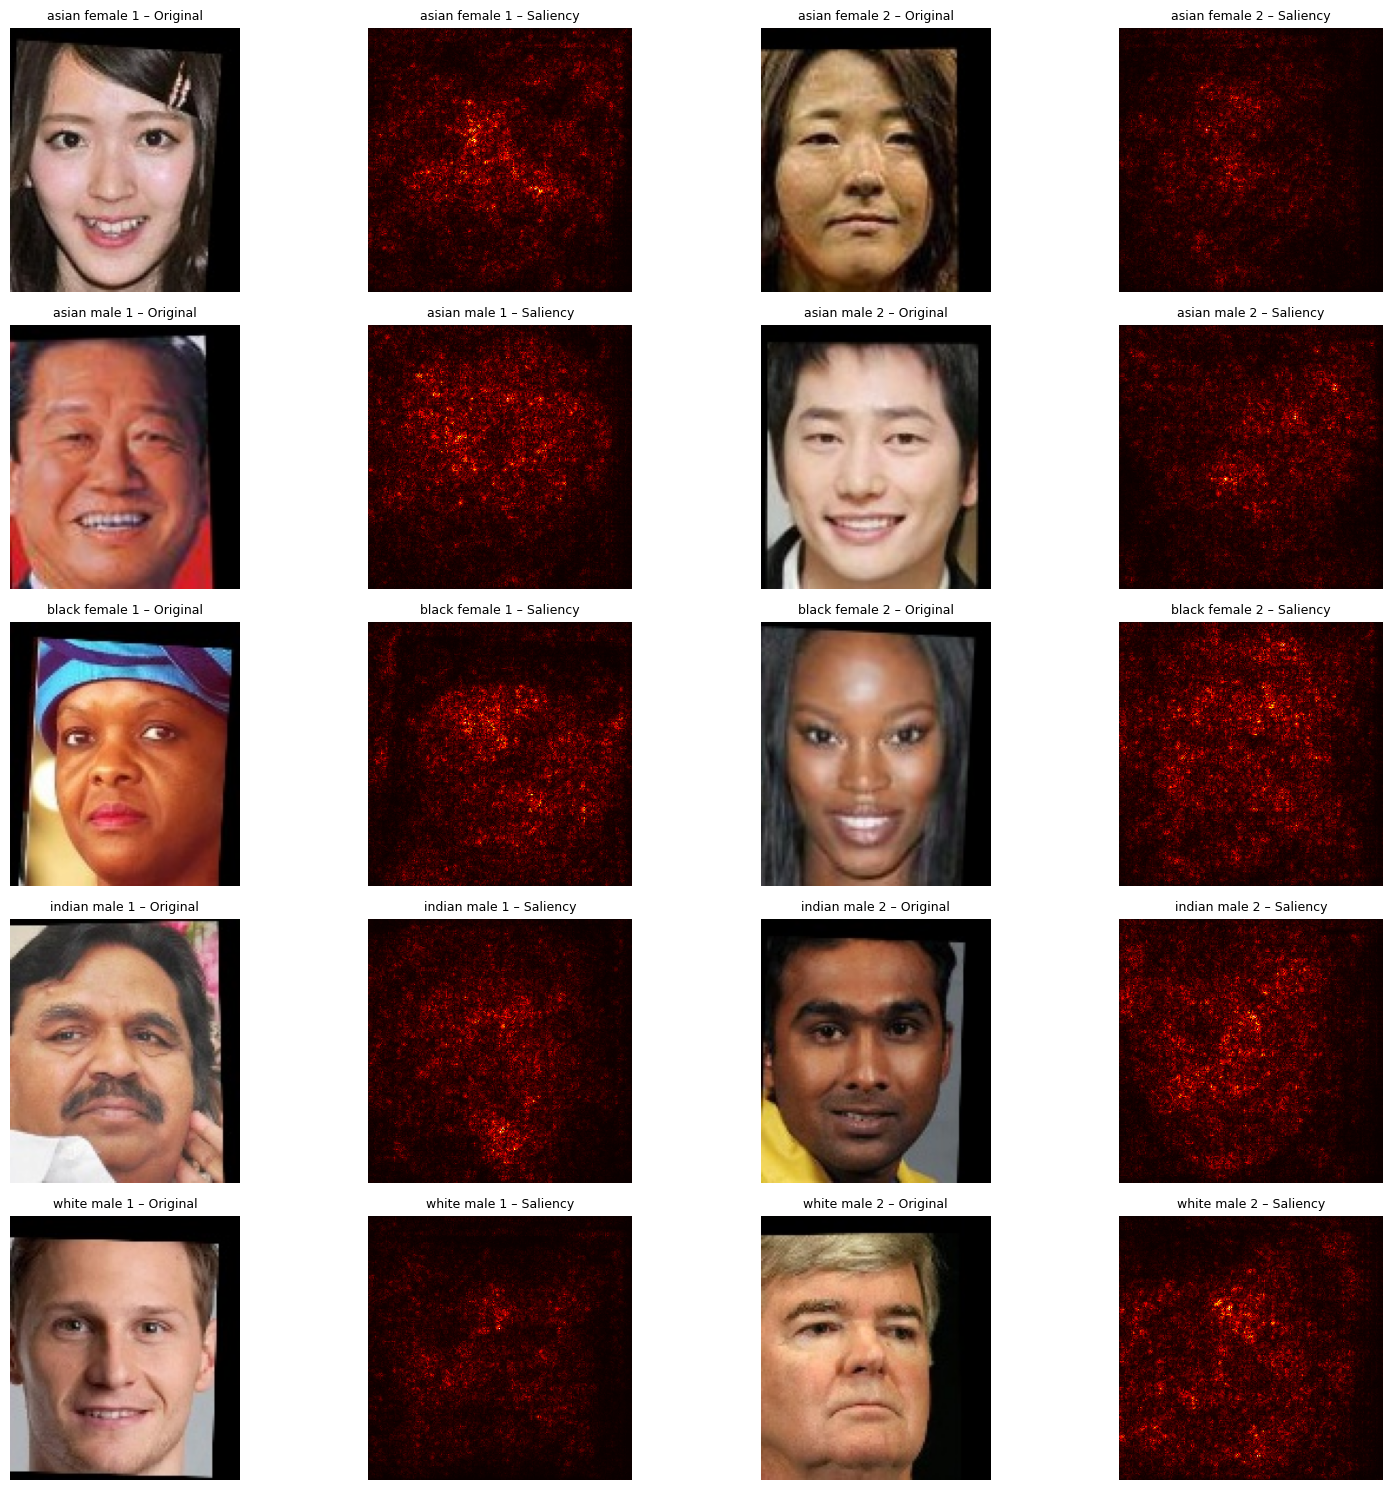

In [ ]:
#Bildpaare gruppieren 
groups = [
    ("asian female",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_females\n000148\0269_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_females\n000838\0500_01.jpg"),

    ("asian male",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_males\n003533\0115_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_males\n004809\0221_01.jpg"),

    ("black female",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\black_females\n003183\0662_02.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\black_females\n002638\0160_01.jpg"),

    ("indian male",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\indian_males\n001998\0063_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\indian_males\n005429\0006_01.jpg"),

    ("white male",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\white_males\n000957\0474_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\white_males\n005685\0073_01.jpg")
]

model.eval()
sal = Saliency(model)

# Saliency & Bilder vorbereiten
rows = []  # pro Gruppe: [(img1, sal1, label), (img2, sal2, label)]

for group_label, img1_path, img2_path in groups:
    row = []
    for img_path in [img1_path, img2_path]:
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0)

        with torch.no_grad():
            logits = model(x)
        pred_class = logits.argmax(1).item()

        attr = sal.attribute(x, target=pred_class)
        attr = attr[0].detach().cpu()
        attr = attr.abs().max(dim=0)[0].numpy()
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

        row.append((img, attr, group_label))
    rows.append(row)

# Plot: pro Reihe Bild1, Sal1, Bild2, Sal2
num_groups = len(rows)
plt.figure(figsize=(16, 3*num_groups))

plot_idx = 1
for (img1, sal1, label1), (img2, sal2, label2) in rows:
    # Bild 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img1)
    plt.title(f"{label1} 1 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # Saliency 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(sal1, cmap="hot")
    plt.title(f"{label1} 1 – Saliency", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # Bild 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img2)
    plt.title(f"{label2} 2 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # Saliency 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(sal2, cmap="hot")
    plt.title(f"{label2} 2 – Saliency", fontsize=9)
    plt.axis("off")
    plot_idx += 1

plt.tight_layout()
plt.show()


### What do we see?
Die Saliency Maps geben uns hier einen ersten Hinweis darauf, auf welche Regionen das Modell schaut, ob es sich auf Gesichtszüge konzentriert oder ob es bei verschiedenen Gruppen unterschiedliche Muster zeigt. Im Kontext von Bias und Fairness ist das wichtig, weil wir wissen wollen ob das Modell bei bestimmten Gruppen weniger klare oder chaotische Aktivierungen zeigt. 

Das Modell fokussiert sich auf zentrale Gesichtsregionen, Hauttextur, Konturen und Schattierungen bzw. hellen Stellen. Die Saliency Maps zeigen, dass das Modell nicht auf einzelne dominante Gesichtsregionen angewiesen ist, sondern eine Vielzahl feiner texturbasierter Signale im gesamten Gesicht nutzt. 
Sie weisen klare Nachteile auf, da sie chaotische, schwer interpetierbare Aktivierungen aufweisen und sensitiv gegenüber kleinen Pixeländerungen ist. Somit haben die Ergebnisse kaum klare Muster und wenig Aussagekraft.

# Integrated Gradients 

Integrated Gradients (IG) is an evolution of simple saliency maps and was developed to address their key weaknesses. But saliency maps are based on a single gradient step, they are highly sensitive to pixel noise, model instabilities, small exposure variations and random gradient noise.

According to the official Captum documentation, sliency maps rely exclusively on local gradients and are therefore highly sensitive to noise and small input perturbations, while IG, by integrating graidents across a path produce more reliable and smoother attributions (Source: Captum – Integrated Gradients & Saliency Documentation, https://captum.ai/).

## Automated Integrated Gradients pipeline 

To analyze multiple samples, we implemented an automated pipeline that processes all selected images in a single batch. For each image the script

1. loads and preprocesses the inpus using the same transformation pipeline as the trained model
2. computes the model prediction to identify the target clas for attribution 
3. generates integrated gradients by integrating gradients along the path from a baseline image (black image) to the actual input
4. converts the resulting attribution tensor into a 2d heatmap, normalised for visualization
5. plots the original image next to its integrated gradients map, allowing direct qualitative comparison
6. automatically saves all generated visualizations into the folder fo documentation and downstream analysis. 

This automatd routine ensures consistent processing, reproducibility and visualization across all demopraphic groups included in the study. 

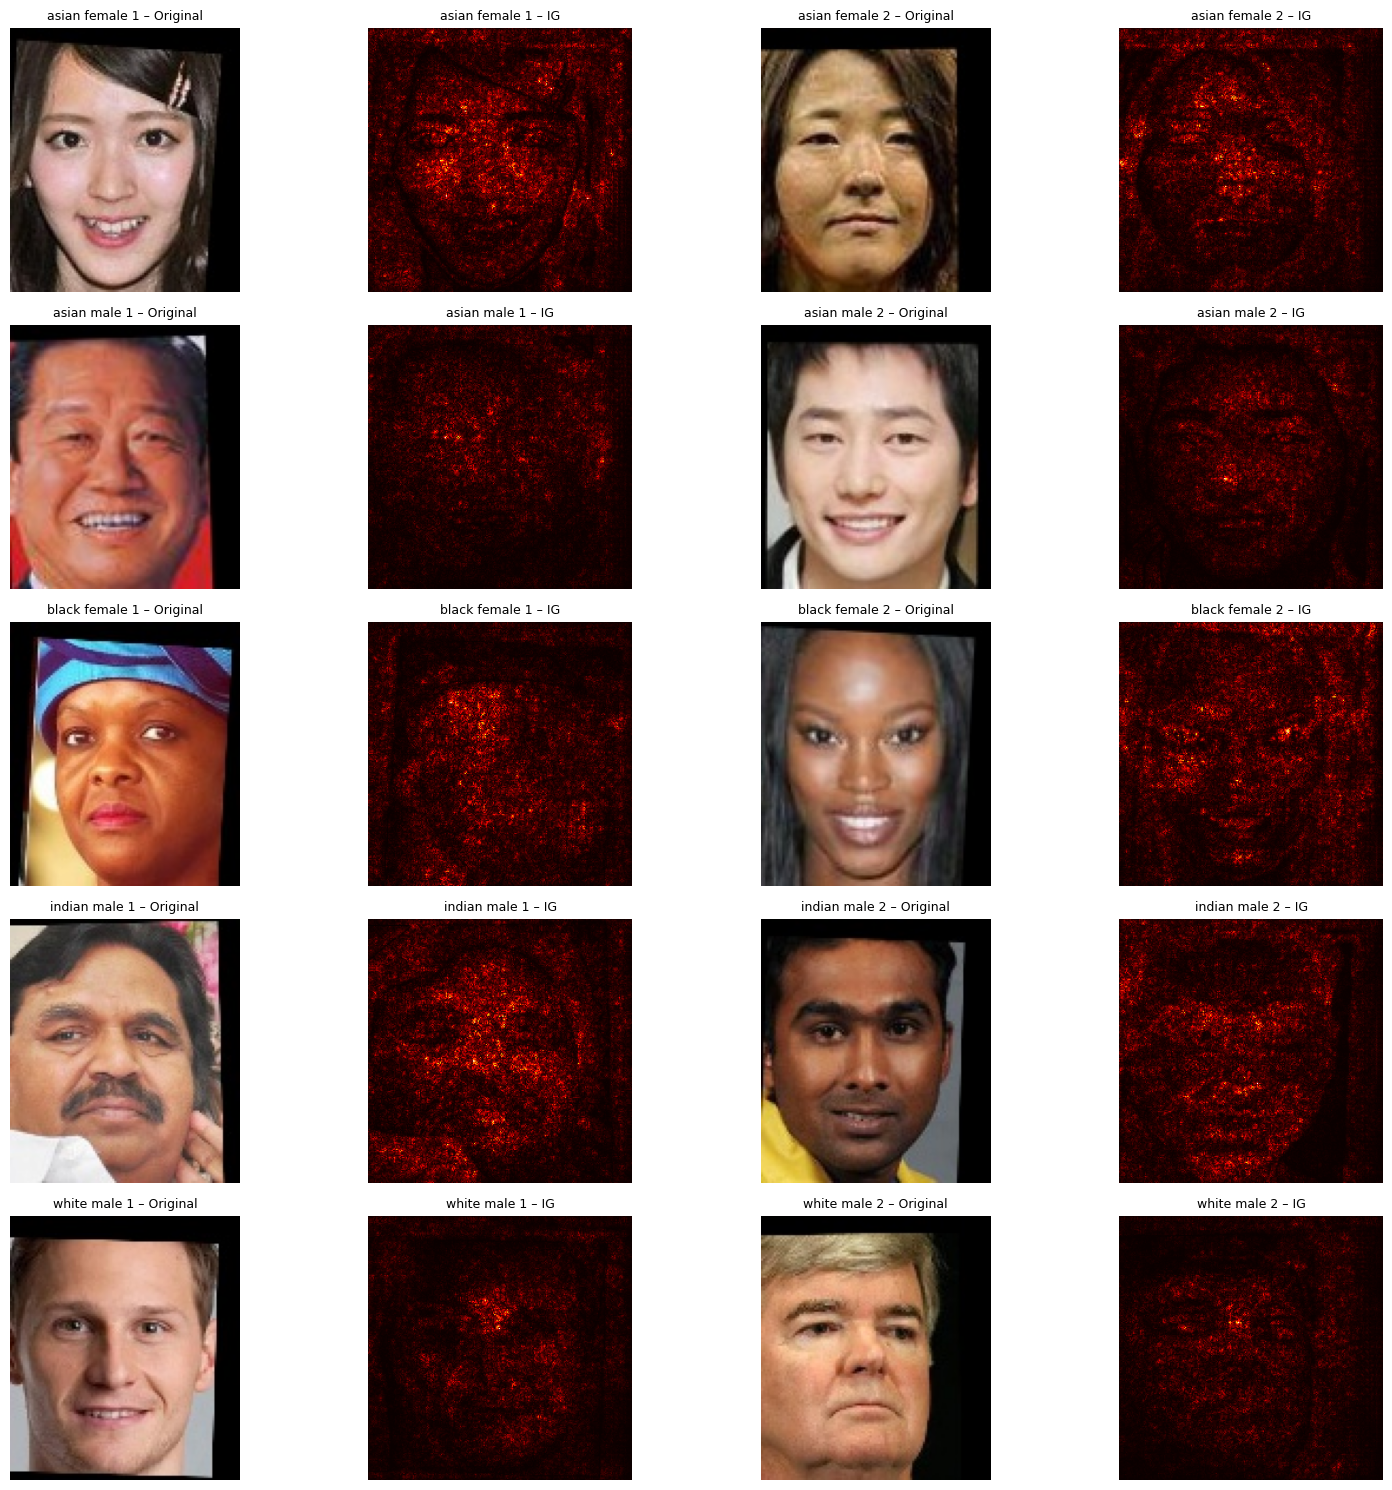

In [ ]:
#  0. Bildpaare gruppieren
groups = [
    ("asian female",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_females\n000148\0269_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_females\n000838\0500_01.jpg"),

    ("asian male",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_males\n003533\0115_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\asian_males\n004809\0221_01.jpg"),

    ("black female",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\black_females\n003183\0662_02.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\black_females\n002638\0160_01.jpg"),

    ("indian male",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\indian_males\n001998\0063_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\indian_males\n005429\0006_01.jpg"),

    ("white male",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\white_males\n000957\0474_01.jpg",
        r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\bfw-cropped-aligned\white_males\n005685\0073_01.jpg")
]

#1. Speicherordner
save_dir_ig = r"C:\Users\SinaElBasiouni\Documents\3. Semester\Deep Learning\tutorial-new-grp5\figures\integrated_gradients"
os.makedirs(save_dir_ig, exist_ok=True)

model.eval()
ig = IntegratedGradients(model)

# Ergebnisse speichern (Original & IG)
rows = []  # jede Reihe = [(img1, ig1, label), (img2, ig2, label)]

for group_label, img1_path, img2_path in groups:
    row = []

    for img_path in [img1_path, img2_path]:

        # 1) Bild laden
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0)

        # 2) Vorhersage
        with torch.no_grad():
            logits = model(x)
        pred_class = logits.argmax(1).item()

        # 3) Integrated Gradients
        baseline = torch.zeros_like(x)
        attr_ig = ig.attribute(x, baselines=baseline, target=pred_class)

        # 4) 2D-Heatmap
        attr = attr_ig[0].detach().cpu()          
        attr = attr.abs().max(dim=0)[0].numpy()   
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

        row.append((img, attr, group_label))

    rows.append(row)

# 2. Plot: Original 1 → IG 1 → Original 2 → IG 2 pro Reihe
num_groups = len(rows)
plt.figure(figsize=(16, 3 * num_groups))

plot_idx = 1
for (img1, ig1, label1), (img2, ig2, label2) in rows:

    # Original 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img1)
    plt.title(f"{label1} 1 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # IG 1
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(ig1, cmap="hot")
    plt.title(f"{label1} 1 – IG", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # Original 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(img2)
    plt.title(f"{label2} 2 – Original", fontsize=9)
    plt.axis("off")
    plot_idx += 1

    # IG 2
    plt.subplot(num_groups, 4, plot_idx)
    plt.imshow(ig2, cmap="hot")
    plt.title(f"{label2} 2 – IG", fontsize=9)
    plt.axis("off")
    plot_idx += 1

plt.tight_layout()
plt.show()


## What do we see?

Die IG-Heatmaps sind deutlich klarer und strukturierter als die Saliency Maps. Wir erkennen, dass es hellere, definiertere Aktivierungsbereiche, weniger Rauschen und bessere Konturen im zentralen Gesichtsbereich gibt. Das Modell verwendet also stabile, widerkehrende Merkmale für die dessen Entscheidung. 
Während die Saliency Maps stark texturgetrieben aussehen, zeigen die IG Maps eine Aktivierung um die Augenregionen, leichte Betonung von Nasenumrissen und Mundkonturen.
